### Background

In the business of keeping subscribed customers, churn is a very important topic. Companies spend time and money generating customers, but then often lose them. An important question that companies may ask is "what factors are associated with an increased probability in customer churn?" and "If certain factors are changed, can we expect a decrease in the probability of churn?". With the answers to these questions, marketing teams can choose which services to focus on, and product teams can seek to improve certain products. With this information a company can make more informed deciscions about what to do to retain valuable customers

### The Data

The data for this project come from IBM’s Church in Telecom Dataset, https://www.ibm.com/communities/analytics/watson-analytics/resources/. The dataset is used to demonstrate some of the exploratory data analysis features of Watson Analytics. The data has features such as services the customer signed up for, customer account information, demographic information, and churn, which in this dataset is defined as whether the customer left within the past month. 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import fmin_powell
from scipy import integrate

import theano as thno
import theano.tensor as T

In [2]:
data = pd.read_csv("ibmchurn.csv")
data.shape

(7043, 21)

In [3]:
churn = 1 * (data['Churn'] == "Yes")

In [4]:
churn.value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

In [5]:
data.drop("Churn", axis=1)
data['churn'] = churn
dataset = data.sample(700) # Pymc3 is having trouble in simulation with more values than this
dataset.shape

(700, 22)

### Exploratory Analysis

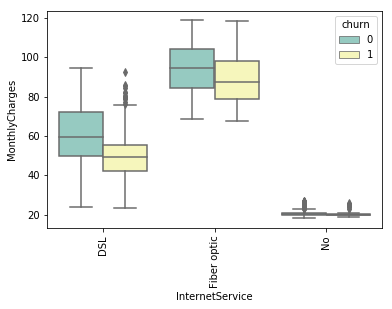

In [6]:
ax = seaborn.boxplot(x="InternetService", y ="MonthlyCharges", hue="churn", data=data, palette="Set3")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax

We can see that monthly charges and internet service type are associated with customer churn.

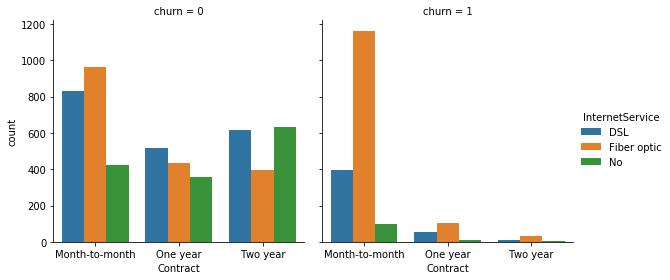

In [7]:
chart = seaborn.catplot(x="Contract", hue="InternetService", col="churn",
               data=data, kind="count",
               height=4);

It is interesting to see that a large number of month-to-month billing service subscribers are churning. Similarly it is interesting that the majority of those churning have fiber obtic internet service and also have a month to month contract.

### The model: Bayesian Logistic Regression Model

The model I will use assumes that the probablility of a customer churning is a function of gender, age, whether or not that person is a senior citizen, whether or not they have dependants, the amount of time with the company, type of internet service, if they have online security, if they have device protection, tech support, steaming TV service, streaming movie service, paperless billing, their payment method, contract type, and their monthly and total charges.

We want to know the posterior probability of the distribution of the parameters. $P(\theta|D)$ = $\frac{P(D|\theta)P(\theta)}{p(D)}$

In order to perform Bayesian logistic regression, we need to specify a prior and a likelihood in order to draw samples from the posterior. Rather than using prior notions of the effects of these factors on customer churn, we will use the default parameters in PyMC3, which gives a very non-informative prior of $N(0, 10^{12}I)$. This is a noniformative prior which will let the data "speak for itself".

The likelihood of the product of n bernoulli trials is $\pi p_i^y(1-p)^{1-y}, for y = \{0,1\} y \in Z$

$Y = b_0 + b_1 Contract + b_2 InternetServie + b_3 tenure + b_4 monthlycharges$

### Can we find the probability of a customer churning given some data about the customer? 

In [8]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('churn ~ Contract + InternetService + tenure + MonthlyCharges', dataset, family=pm.glm.families.Binomial())
    trace_logistic_model = pm.sample(1500, chains=2, tune=1000)  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [MonthlyCharges, tenure, InternetService[T.No], InternetService[T.Fiber optic], Contract[T.Two year], Contract[T.One year], Intercept]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 5000/5000 [01:04<00:00, 77.94draws/s]


In [9]:
## Helper function taken from PyMC3 tutorial documentation 
def plot_traces(traces, retain=1000):
    '''
    Convenience function:
    Plot traces with overlaid means and value
    '''

    ax = pm.traceplot(traces[-retain:], figsize=(12,len(traces.varnames)*1.5),
        lines={k: v['mean'] for k, v in pm.summary(traces[-retain:]).iterrows()})

    for i, mn in enumerate(pm.summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')

Below you can see that trace plot of the Hamiltonion MCMC simulation

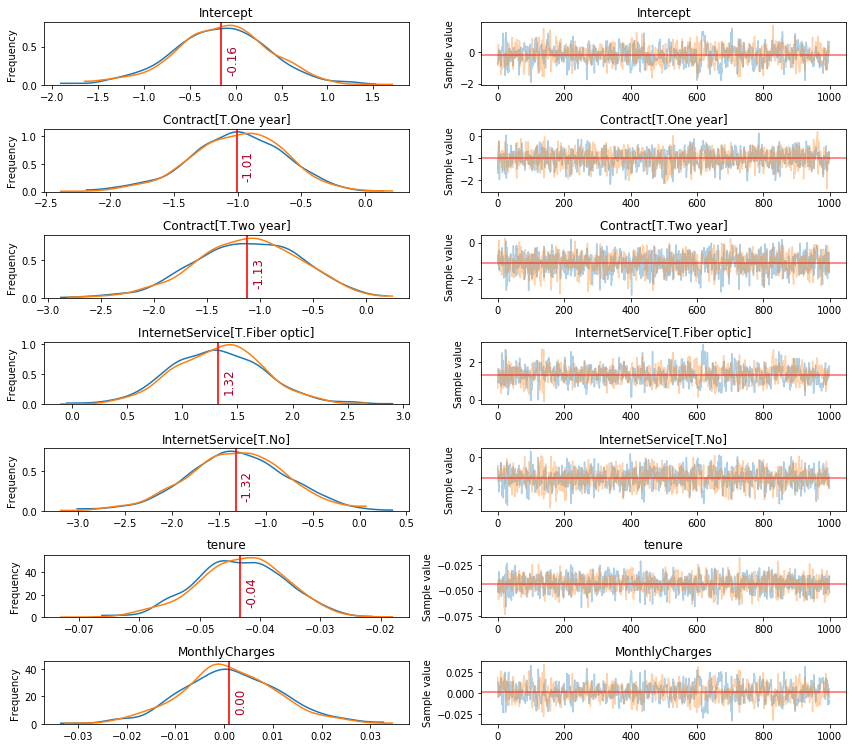

In [10]:
plot_traces(trace_logistic_model, retain=1000)

In [11]:
pm.summary(trace_logistic_model)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,-0.140251,0.535038,0.016927,-1.177952,0.965050,957.303579,0.999689
Contract[T.One year],-1.003319,0.362562,0.008766,-1.766046,-0.337815,1568.528354,0.999722
Contract[T.Two year],-1.131783,0.500482,0.012807,-2.066848,-0.146729,1385.690642,1.000039
InternetService[T.Fiber optic],1.336076,0.419526,0.013158,0.542906,2.171667,947.882334,0.999685
InternetService[T.No],-1.337087,0.533445,0.013363,-2.401210,-0.298221,1445.015591,0.999751
tenure,-0.043221,0.007278,0.000154,-0.056943,-0.028973,1722.927086,0.999793
MonthlyCharges,0.000693,0.010146,0.000341,-0.018606,0.021777,845.377767,0.999692


Above we see the predicted coefficients of the logistic regression model. The only 95% credible set for the coefficients that contains the value zero is the monthlycharges, which shows that monthly charges is not statistically significantly different from zero. The others: contract, internet service, and tenure, are all statistically significantly different from zero. 

In [12]:
def logit2prob(logit):
    odds = np.exp(logit)
    prob = odds / (1 + odds) * 100
    return(np.round(prob,2))

In [13]:
print("Contract (One year): {}%".format(logit2prob(-.931003)))
print("Contract (Two year): {}%".format(logit2prob(-1.518044)))
print("Internet (Fiber Optic): {}%".format(logit2prob(1.861680)))

Contract (One year): 28.27%
Contract (Two year): 17.97%
Internet (Fiber Optic): 86.55%


We can see that a one year contract is associated with a 65% decrease in the probability of churn compared to a month to month contract  and a two year contract is associated with a 28% decrease in the probabilty of churn. 


Fiber optic internet service is associated with a decrease in the probability of churn of 86.55%  

In [14]:
print("Odds of tenure: {}".format(np.exp(-0.37688)))

Odds of tenure: 0.6859983887636809


We can see that a unit increase in the tenure of a customer is associated with a 6.8% increase in the odds of churn. 

A company may also find it useful to use the model to predict the probability of churn of a specific customer. Below I get the medians of each of the attributes and the frequencies of the categorical variables to create a datapoint for the average customer. 

In [15]:
data.median(axis=0)

SeniorCitizen      0.00
tenure            29.00
MonthlyCharges    70.35
churn              0.00
dtype: float64

In [16]:
data['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64

In [17]:
data['Contract'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64

We can now predict the probability of churn of a customer with a tenure of 31 months, monthly charges of \$67.77, Fiber Optic Service, and a month to month contract. 

In [18]:
logit = .695576 +1.861680 - .037688*(31) -.015197*(67.77)
print("This customer has a {}% probability of churning".format(logit2prob(logit)))

This customer has a 58.88% probability of churning


Based on the logistic regression model, we predict that the "median" customer has a 58% probability of churning. We can also see that contract type and internet service have a large impact on this.

This however may not be the whole story for customer churn. As pointed out in a recent article by Uber Engineering, "Modeling Censored Time-to-Event Data Using Pyro", customer churn can be a misleading metric for some industries. For example, an Uber rider that only rides on Holidays may be labeled as "churning" because another holiday has not passed since the data were collected in the study. Similarly here a custer may be about to churn but simply hasn't because the study took place before they did, thus leading to an incomplete assessment. An extension of this analysis could be to look at customer churn in the light of censored time to events (survival analysis).